# Technical Test Pythae

To run this notebook you will need a Python version >=3.8

## Preliminaries: Setup environnement & Data

In [26]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import matplotlib.pyplot as plt  

import torchio as tio 
import torch

from data.config import ConfigIRCAD

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
from data.dataset import IRCAD
from pythae.data.datasets import DatasetOutput

class IRCAD_pythae(IRCAD):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        
    def __getitem__(self, index: int) :
        subject = super().__getitem__(index) 
        #return subject['ct']['data'].float()
        return DatasetOutput(
            data=subject['ct']['data'].float(),
            #labels=subject['cancer'].float()
        )

In [58]:
mount_dir = Path("/mnt/Shared/") if Path.exists(Path("/mnt/Shared/")) else Path.home() / "data"
root_data_dir = mount_dir / "3Dircadb1"

transforms = [
    tio.ToCanonical(),  # to RAS
    tio.Clamp(-150, 250),
    tio.RescaleIntensity(out_min_max=(0, 1)),
    tio.Resample((1, 1, 2)),  # to 1 mm iso
    tio.CropOrPad((64,64,16), mask_name='liver'),
    ]

config = ConfigIRCAD(root_data_dir)

train_dataset = IRCAD_pythae(
    config=config,
    subset='train',
    transform=tio.Compose(transforms),
)
eval_dataset = IRCAD_pythae(
    config=config,
    subset='test',
    transform=tio.Compose(transforms),
)

## Step 1: Training a VAE with Pythae

To train a VAE with Pythae, the first step is to define the configuration you want to apply to your
autoencoder model. This will be used to instantiate the VAE instance. Then, you will need to
setup the training configuration and launch a training.

**Objective: Complete the following code based so you can launch a training using Pythae's model.**

Required training setup:
- The model should have a latent dimension of 8
- Train the model for 50 epochs, a learning rate of 3e-3 and batch_size of 64
- Save the best model on validation set in a folder named `experiments`

In [36]:
from pythae.models import VAEConfig, VAE

model_config = VAEConfig(
    input_dim=(1,64,64,16),
    latent_dim=8
)

model = VAE(
    model_config=model_config
)


In [37]:
from pythae.trainers import BaseTrainerConfig, BaseTrainer


training_config = BaseTrainerConfig(
    output_dir='experiments',
    num_epochs=5,
    learning_rate=3e-3,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
)

trainer = BaseTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    training_config=training_config
)

trainer.train()

Model passed sanity check !
Ready for training.

Created experiments/VAE_training_2024-02-01_16-55-04. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 5
 - per_device_train_batch_size: 2
 - per_device_eval_batch_size: 2
 - checkpoint saving every: None
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.003
    maximize: False
    weight_decay: 0
)
Scheduler: None

Successfully launched training !



Training of epoch 1/5:   0%|          | 0/4 [00:00<?, ?batch/s]

Eval of epoch 1/5:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 202476005.6511
Eval loss: 16912317952.0
--------------------------------------------------------------------------


Training of epoch 2/5:   0%|          | 0/4 [00:00<?, ?batch/s]

Eval of epoch 2/5:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 118656114152.8552
Eval loss: 11397.5107
--------------------------------------------------------------------------


Training of epoch 3/5:   0%|          | 0/4 [00:00<?, ?batch/s]

Eval of epoch 3/5:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9277.4685
Eval loss: 9126.2764
--------------------------------------------------------------------------


Training of epoch 4/5:   0%|          | 0/4 [00:00<?, ?batch/s]

Eval of epoch 4/5:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 8613.4945
Eval loss: 33929.7607
--------------------------------------------------------------------------


Training of epoch 5/5:   0%|          | 0/4 [00:00<?, ?batch/s]

Eval of epoch 5/5:   0%|          | 0/2 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10091.5173
Eval loss: 9842.1074
--------------------------------------------------------------------------
Training ended!
Saved final model in experiments/VAE_training_2024-02-01_16-55-04/final_model


# Step 2: Defining a custom encoder.

Pythae provides the user with the possibility to create its own encoder
and decoder networks. 

**Objective: Complete the following code to train a VAE with a custom encoder network chosen as a
Convolutional Neural Net**

In [ ]:
import torch.nn as nn
from pythae.models.nn import BaseEncoder
from pythae.models.base.base_utils import ModelOutput


class CustomEncoder(BaseEncoder):
    def __init__(self, args=None):
        BaseEncoder.__init__(self)
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=0),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=0),
            nn.AvgPool2d(kernel_size=6),
        )
        self.embedding = nn.Linear(64, 8)
        self.log_covariance = nn.Linear(64, 8)

    def forward(self, x: torch.Tensor) -> ModelOutput:
        out = self.layers(x).squeeze()
        output = ModelOutput(
            embedding=self.embedding(out),
            log_covariance=self.log_covariance(out)
        )
        return output

custom_encoder = CustomEncoder()  

In [ ]:
from torchsummary import summary
summary(custom_encoder, (1,64,64,16))

In [ ]:
model_config = VAEConfig(
    input_dim=(1,64,64,16),
    latent_dim=8
)

model = VAE(
    model_config=model_config,
    encoder=custom_encoder  
)

In [ ]:
training_config = BaseTrainerConfig(
    output_dir='experiments/custom',
    num_epochs=5,
    learning_rate=3e-3,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=4,
)

trainer = BaseTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    training_config=training_config
)

trainer.train()

# Step 3: Generating synthetic images with PythAE

Pythae makes available several sampling methods that allow the users to generate synthetic data
directly from a trained model.

**Objective: Use one the models you have previously trained and generate synthetic images**

Required setting:
- Generate 16 images using the `NormalSampler`
- Generate 24 images using a Gaussian Mixture with 7 Gaussians

*Note: Do not expect the generation to be good given the model chosen, the number of training
samples and the training time. This exercise is meant to see how familiar you are with Pythae and
VAEs in general*

In [44]:
from pythae.models import AutoModel

import glob

dir_path = glob.glob('experiments/VAE_training_*/final_model')[0]
trained_model = AutoModel.load_from_folder(dir_path)

print("Loaded {} model from {}".format(trained_model.__class__, dir_path))

Loaded <class 'pythae.models.vae.vae_model.VAE'> model from experiments/VAE_training_2024-02-01_16-55-04/final_model


In [45]:
from pythae.samplers import NormalSampler


sampler = NormalSampler(
    model=trained_model,
    sampler_config=None
)
gen_data = sampler.sample(
    num_samples=9,
)

print(gen_data.shape)

torch.Size([9, 1, 64, 64, 16])


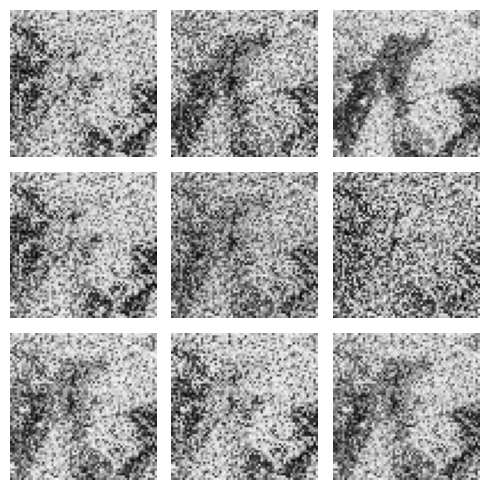

In [48]:
import matplotlib.pyplot as plt


_, ax = plt.subplots(nrows=3, ncols=3, figsize=(5,5))

for i in range(3):
    for j in range(3):
        ax[i][j].imshow(gen_data[i*3+j,0,:,:,8].data, cmap='gray')
        ax[i][j].axis('off')
plt.tight_layout()

In [80]:
%%time

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=6, shuffle=True)
train_fit_subset = next(iter(train_loader))
print(train_fit_subset.data.shape)

torch.Size([6, 1, 64, 64, 16])
CPU times: user 46 s, sys: 6.04 s, total: 52 s
Wall time: 38.3 s


In [78]:
from pythae.samplers import GaussianMixtureSampler, GaussianMixtureSamplerConfig


gmm_sampler_config = GaussianMixtureSamplerConfig(
    n_components=7
)

gmm_sampler = GaussianMixtureSampler(
    sampler_config=gmm_sampler_config,
    model=trained_model
)

gmm_sampler.fit(
    train_data=train_fit_subset.data
)

gmm_gen_data = gmm_sampler.sample(
   num_samples=9
)

Setting the number of component to 6 sincen_components > n_samples when fitting the gmm


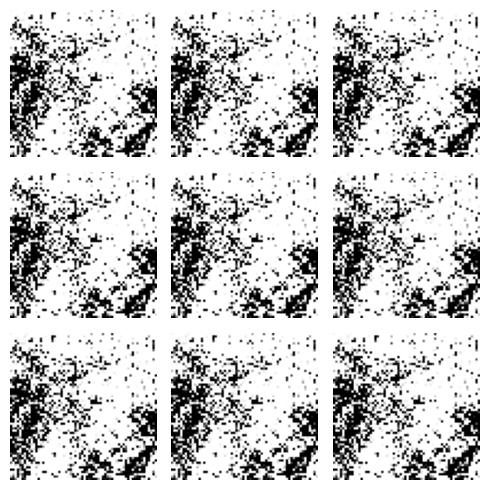

In [79]:
import matplotlib.pyplot as plt


_, ax = plt.subplots(nrows=3, ncols=3, figsize=(5,5))

for i in range(3):
    for j in range(3):
        ax[i][j].imshow(gmm_gen_data[i*3+j,0,:,:,8].data, cmap='gray')
        ax[i][j].axis('off')
plt.tight_layout()